# 불량품 예측

불량품을 예측하기 위해 다음과 같은 함수화 정리를 진행한다. 혼란을 막기 위해 모든 과정을 함수화 하기로 한다.  
목차는 다음과 같다.

- 1. Load packages & Data
- 2. Function

## 1. Load Packages & Data

In [1]:
### ide packages
import os
from pprint import pprint
import numpy as np
import pandas as pd
import random
import string
from tqdm import tqdm

# sklearn preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    make_scorer,
    roc_curve,
    auc,
    precision_recall_curve,
    recall_score,
    silhouette_score,
)

# models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier, plot_metric
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.cluster import KMeans

# plot
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px

# tuning
import optuna

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data
load_dir = './data/'
train = pd.read_csv(load_dir + "train.csv")
test = pd.read_csv(load_dir + "test.csv")

## 2. Functions

In [3]:
# 평가 스코어 지정하기
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

# 평가 매트릭 계산 결과 보여주기
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [4]:
# 해당 공정 맞춤형 위치 옮기기
def move_data(data):
    # divide
    dam = data.filter(regex='_Dam')
    fill1 = data.filter(regex='_Fill1')
    fill2 = data.filter(regex='_Fill2')
    autoclave = data.filter(regex='_AutoClave')
    target = data['target']

    # dam
    dam = dam.dropna(axis=1, how='all')
    dam = dam.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam')
    dam_mask = dam[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
    dam.loc[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan]), dam.columns[24:]] = dam_mask
    dam = dam.drop(columns='WorkMode Collect Result_Dam')

    # fill1
    fill1 = fill1.dropna(axis=1, how='all')
    fill1 = fill1.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1')
    fill1_mask = fill1[fill1['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan])].iloc[:, 14:].shift(-1, axis = 1).values
    fill1.loc[fill1['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan]), fill1.columns[14:]] = fill1_mask
    fill1 = fill1.drop(columns='WorkMode Collect Result_Fill1')

    # fill2
    fill2 = fill2.dropna(axis=1, how='all')
    fill2 = fill2.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2')
    fill2_mask = fill2[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
    fill2.loc[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan]), fill2.columns[24:]] = fill2_mask
    fill2 = fill2.drop(columns='WorkMode Collect Result_Fill2')

    # CONCAT
    data = pd.concat([dam, fill1, fill2, autoclave, target], axis=1)
    
    return data

In [5]:
# 칼럼 위치 변경
def swap_columns(df, condition, col1, col2):
    # 조건에 해당하는 행 필터링
    filtered_df = df[condition]
    
    # 값 교환
    df.loc[condition, [col1, col2]] = filtered_df[[col1, col2]].copy().iloc[:, ::-1].values

    return df

In [6]:
# Equipment 방향 통일과 잘못된 위치 재조정하기
def change_data(train, test):
    # train
    train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float)
    train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] = train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float)


    # 이동 전
    X_sum_down_1 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float).mean()
    X_sum_down_2 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float).mean()
    X_sum_up_1 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float).mean()
    X_sum_up_2 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float).mean()

    X_sum_down = (X_sum_down_1 - X_sum_down_2) / 2 # stage1에서 빼고, Stage3에서 더하기 <500
    X_sum_up = (X_sum_up_2 - X_sum_up_1) / 2 # stage1에서 더하고, Stage 3에서 빼기

    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] += X_sum_up
    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] -= X_sum_up

    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] -= X_sum_down
    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] += X_sum_down

    # test
    test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float)
    test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] = test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float)


    # 이동 전
    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] += X_sum_up
    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] -= X_sum_up

    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] -= X_sum_down
    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] += X_sum_down

    # train
    Y_sum_dam_1 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float).mean()
    Y_sum_dam_2 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'] = Y_sum_dam_1 + Y_sum_dam_2 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam']

    Y_sum_dam_3 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float).mean()
    Y_sum_dam_4 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'] = Y_sum_dam_3 + Y_sum_dam_4 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam']

    Y_sum_dam_5 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float).mean()
    Y_sum_dam_6 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'] = Y_sum_dam_5 + Y_sum_dam_6 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam']

    Y_sum_fill_1 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float).mean()
    Y_sum_fill_2 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'] = Y_sum_fill_1 + Y_sum_fill_2 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1']

    Y_sum_fill_3 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float).mean()
    Y_sum_fill_4 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'] = Y_sum_fill_3 + Y_sum_fill_4 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1']

    Y_sum_fill_5 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float).mean()
    Y_sum_fill_6 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float).mean()
    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'] = Y_sum_fill_5 + Y_sum_fill_6 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1']

    # test
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'] = Y_sum_dam_1 + Y_sum_dam_2 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'] = Y_sum_dam_5 + Y_sum_dam_6 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'] = Y_sum_dam_3 + Y_sum_dam_4 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'] = Y_sum_fill_1 + Y_sum_fill_2 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'] = Y_sum_fill_5 + Y_sum_fill_6 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'] = Y_sum_fill_3 + Y_sum_fill_4 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1']

    ### Train
    # 조건을 만족하는 행 인덱스를 찾음
    condition = train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) >= 200

    # DISCHARGED TIME OF RESIN(Stage1) 
    swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam')

    # Dispense Volume(Stage1)
    swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam')

    # Stage1 Circle1 Distance Speed Collect
    swap_columns(train, condition, 'Stage1 Circle1 Distance Speed Collect Result_Dam', 'Stage3 Circle1 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Circle2 Distance Speed Collect Result_Dam', 'Stage3 Circle2 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Circle3 Distance Speed Collect Result_Dam', 'Stage3 Circle3 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Circle4 Distance Speed Collect Result_Dam', 'Stage3 Circle4 Distance Speed Collect Result_Dam')

    # Stage1 Line1 Distance Speed Collect
    swap_columns(train, condition, 'Stage1 Line1 Distance Speed Collect Result_Dam', 'Stage3 Line1 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Line2 Distance Speed Collect Result_Dam', 'Stage3 Line2 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Line3 Distance Speed Collect Result_Dam', 'Stage3 Line3 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Line4 Distance Speed Collect Result_Dam', 'Stage3 Line4 Distance Speed Collect Result_Dam')

    # THICKNESS 1
    # swap_columns(train, condition, 'THICKNESS 1 Collect Result_Dam', 'THICKNESS 3 Collect Result_Dam')

    ### 젤 마지막에 와야됨!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam')


    ### Test
    # 조건을 만족하는 행 인덱스를 찾음
    condition = test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) >= 200

    # DISCHARGED TIME OF RESIN(Stage1) 
    swap_columns(test, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam')

    # Dispense Volume(Stage1)
    swap_columns(test, condition, 'Dispense Volume(Stage1) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam')

    # Stage1 Circle1 Distance Speed Collect
    swap_columns(test, condition, 'Stage1 Circle1 Distance Speed Collect Result_Dam', 'Stage3 Circle1 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Circle2 Distance Speed Collect Result_Dam', 'Stage3 Circle2 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Circle3 Distance Speed Collect Result_Dam', 'Stage3 Circle3 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Circle4 Distance Speed Collect Result_Dam', 'Stage3 Circle4 Distance Speed Collect Result_Dam')

    # Stage1 Line1 Distance Speed Collect
    swap_columns(test, condition, 'Stage1 Line1 Distance Speed Collect Result_Dam', 'Stage3 Line1 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Line2 Distance Speed Collect Result_Dam', 'Stage3 Line2 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Line3 Distance Speed Collect Result_Dam', 'Stage3 Line3 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Line4 Distance Speed Collect Result_Dam', 'Stage3 Line4 Distance Speed Collect Result_Dam')

    # THICKNESS 1
    # swap_columns(train, condition, 'THICKNESS 1 Collect Result_Dam', 'THICKNESS 3 Collect Result_Dam')

    ### 젤 마지막에 와야됨!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam')
    
    ### Train
    # 조건을 만족하는 행 인덱스를 찾음
    condition = train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].astype(float) < 200

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1')

    ### Test
    condition = test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].astype(float) < 200

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(test, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(test, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1')
    
    ### Train
    condition = train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1')

    ### Test
    condition = test['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(test, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(test, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1')

    return train, test

In [7]:
# Dam, Fill1, Fill2에서 지정된 값이 다를 경우 Abnormal 
def inconsistant(data, columnname, iwantthiscolumnsname, is_train = True):
    # 장비 번호가 다르면 불일치
    if is_train:
        cri = [
            df_train[columnname + '_Dam'] != df_train[columnname + '_Fill1'],
            df_train[columnname + '_Dam'] != df_train[columnname + '_Fill2'],
            df_train[columnname + '_Fill1'] != df_train[columnname + '_Fill2'],
            data[iwantthiscolumnsname] == 1
        ]
        
    else:
        cri = [
            df_test[columnname + '_Dam'] != df_test[columnname + '_Fill1'],
            df_test[columnname + '_Dam'] != df_test[columnname + '_Fill2'],
            df_test[columnname + '_Fill1'] != df_test[columnname + '_Fill1'],
            data[iwantthiscolumnsname] == 1
        ]
    con = [1, 1, 1, 1]

    data[iwantthiscolumnsname] = np.select(cri, con, default = 0)

In [8]:
# 변수 세팅
def variable_setting(types, tr, te, columns_to_convert, columns_to):
    train = tr.copy()
    test = te.copy()
    
    if types == 'catboost':
        dtype = 'string'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)

        dtype = 'category'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)
            
    elif types == 'lightgbm':
        dtype = 'float'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)

        dtype = 'category'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)
            
    elif types == 'xgboost':
        dtype = 'float'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)
            
    return train, test

In [9]:
def model_best_threshold(model, X_valid, y_valid):
    # Precision - Recall
    y_pred_proba = model.predict_proba(X_valid)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba)
    f1_scores = 2*recall*precision / (recall + precision)
    cat_best_threshold = thresholds[np.argmax(f1_scores)]
    y_pred_custom_threshold = (y_pred_proba >= cat_best_threshold).astype(int)
    
    return thresholds, y_pred_custom_threshold

In [10]:
def xgboost_optuna(train, cat_features_indices):
    X = train.drop(columns=['target'])
    y = train['target']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        }

        model = xgb.XGBClassifier(eval_metric='logloss', **params)

        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)

        preds = model.predict(X_valid)
        f1 = f1_score(y_valid, preds)

        return f1

    # Optuna 스터디 생성 및 최적화
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=50)

    # 최적의 하이퍼파라미터 출력
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    return study.best_trial.params, X, y, X_train.index, X_valid.index

In [11]:
def lightgbm_optuna(train, cat_features_indices):

    X = train.drop(columns=['target'])
    y = train['target']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    def objective(trial):
        lgbm_params = {
            'n_estimators': trial.suggest_int('n_estimators', 400, 1500),
            "max_depth": trial.suggest_int('max_depth', 3, 63),
            "learning_rate": trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True), 
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
            "min_child_weight": trial.suggest_float('min_child_weight', 0.5, 4),
            "min_child_samples": trial.suggest_int('min_child_samples', 5, 100),
            "subsample": trial.suggest_float('subsample', 0.4, 1),
            "subsample_freq": trial.suggest_int('subsample_freq', 0, 5),
            "colsample_bytree": trial.suggest_float('colsample_bytree', 0.2, 1),
            'num_leaves': trial.suggest_int('num_leaves', 2, 64),
        }

        model = LGBMClassifier(**lgbm_params, device='cpu', random_state=42, verbose=-1)

        # 범주형 피처 적용
        model.fit(X_train, y_train, categorical_feature=cat_features_indices)

        # 검증 데이터에서 예측 수행
        y_pred = model.predict(X_valid)

        # F1 점수 계산
        f1 = f1_score(y_valid, y_pred)

        return f1

    # Optuna 스터디 생성 및 최적화
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=50)

    # 최적의 하이퍼파라미터 출력
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    return study.best_trial.params, X, y, X_train.index, X_valid.index

In [12]:
def catboost_optuna(train, cat_features_indices):
    
    # train X, y
    X = train.drop(columns=['target'])
    y = train['target']

    # $plit 
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    # Pooling
    train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices)
    
    # tuning parameters
    def objective(trial):
        # 하이퍼파라미터를 샘플링
        params = {
            "iterations": trial.suggest_int("iterations", 100, 1000),
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
            "border_count": trial.suggest_int("border_count", 32, 255),
            "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
            "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
            "od_wait": trial.suggest_int("od_wait", 10, 50),
            "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#             "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
            "verbose": 0,
            "random_seed": 42
        }

        # CatBoost 모델 학습
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)

        # 검증 세트에 대한 예측 및 평가
        preds = model.predict(X_valid)
        f1 = f1_score(y_valid, preds)

        return f1

    # Optuna 스터디 생성 및 최적화
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=12)

    # 최적의 하이퍼파라미터 출력
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    return study.best_trial.params, X, y, X_train.index, X_valid.index

## 3. Setting

In [13]:
# 기준
columnname = ['Equipment', 'Receip No Collect Result', 'Production Qty Collect Result', 'PalletID Collect Result', ]

In [14]:
# drop oolumns
drop_col = [
    'Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Circle3 Distance Speed Collect Result_Dam',
    'Stage1 Circle4 Distance Speed Collect Result_Dam', 
    'Stage2 Circle2 Distance Speed Collect Result_Dam',
    'Stage2 Circle3 Distance Speed Collect Result_Dam',
    'Stage2 Circle4 Distance Speed Collect Result_Dam', 
    'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Circle3 Distance Speed Collect Result_Dam',
    'Stage3 Circle4 Distance Speed Collect Result_Dam',
    
    # Dam, Fill2의 경우 Z값이 서로 같다. -> 그렇다면 Fill1은 높이값에서 흔들린 경우가 있다는 것을 의미한다.
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2',
    
    # 의미를 찾을 수 없는 컬럼들 제거
    'Wip Line_Fill1', 
    'Process Desc._Fill1', 
    'Insp. Seq No._Fill1', 
    'Insp Judge Code_Fill1', 
    'Equipment_AutoClave',
    'Process Desc._AutoClave', 
    'Wip Line_AutoClave', 
    'Insp Judge Code_AutoClave',
    'Insp. Seq No._AutoClave',
    '1st Pressure Judge Value_AutoClave', 
    '2nd Pressure Judge Value_AutoClave', 
    '3rd Pressure Judge Value_AutoClave', 
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Unit Time_AutoClave',
    'Wip Line_Fill2', 
    'Process Desc._Fill2', 
    'Insp. Seq No._Fill2', 
    'Insp Judge Code_Fill2', 
    'Wip Line_Dam', 
    'Process Desc._Dam', 
    'Insp. Seq No._Dam', 
    'Insp Judge Code_Dam',
    'CURE END POSITION X Collect Result_Dam',
    'CURE END POSITION Z Collect Result_Dam',
    'CURE END POSITION Θ Collect Result_Dam',
    'CURE STANDBY POSITION X Collect Result_Dam',
    'CURE STANDBY POSITION Z Collect Result_Dam',
    'CURE STANDBY POSITION Θ Collect Result_Dam',
    
    # Fill2는 레진을 살포하지 않는다. UV만 진행하는 과정이므로 싹 삭제해 준다.          
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
    'HEAD Standby Position X Collect Result_Fill2',
    'HEAD Standby Position Y Collect Result_Fill2',
    'HEAD Standby Position Z Collect Result_Fill2',
    'Head Clean Position X Collect Result_Fill2',
    'Head Clean Position Y Collect Result_Fill2',
    'Head Clean Position Z Collect Result_Fill2',
    'Head Purge Position X Collect Result_Fill2',
    'Head Purge Position Y Collect Result_Fill2',
    'Head Purge Position Z Collect Result_Fill2',
    'DISCHARGED SPEED OF RESIN Collect Result_Fill2',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill2',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill2',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill2',
    'Dispense Volume(Stage1) Collect Result_Fill2',
    'Dispense Volume(Stage2) Collect Result_Fill2',
    'Dispense Volume(Stage3) Collect Result_Fill2',
    
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line3 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam',
    'Stage2 Line1 Distance Speed Collect Result_Dam',
    'Stage2 Line2 Distance Speed Collect Result_Dam',
    'Stage2 Line3 Distance Speed Collect Result_Dam',
    'Stage2 Line4 Distance Speed Collect Result_Dam',
    'Stage3 Line1 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line3 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam',
    
    # 단일값이 하나인 컬럼들, 의미를 찾고싶다면 주석처리 해야하는 것들
    'CURE START POSITION X Collect Result_Dam', # Equipment에 따라서 정해지며, 하나로 책정됨.
    'CURE START POSITION Z Collect Result_Dam', # START POSITION
    'CURE START POSITION Θ Collect Result_Dam', # Equipment에 따라서 정해지며, 하나로 책정됨.
    'HEAD Standby Position X Collect Result_Dam',
    'HEAD Standby Position Y Collect Result_Dam',
    'HEAD Standby Position Z Collect Result_Dam',
    'Head Clean Position X Collect Result_Dam',
    'Head Clean Position Y Collect Result_Dam', # 흔들림에 따라 Z
    'Head Purge Position X Collect Result_Dam',
    'Head Purge Position Y Collect Result_Dam',
    'Head Zero Position X Collect Result_Dam',
    'HEAD Standby Position X Collect Result_Fill1',
    'HEAD Standby Position Y Collect Result_Fill1',
    'HEAD Standby Position Z Collect Result_Fill1',
    'Head Clean Position X Collect Result_Fill1',
    'Head Clean Position Y Collect Result_Fill1',
    'Head Clean Position Z Collect Result_Fill1',
    'Head Purge Position X Collect Result_Fill1',
    'Head Purge Position Y Collect Result_Fill1',
    'CURE END POSITION X Collect Result_Fill2',
    'CURE END POSITION Θ Collect Result_Fill2',
    'CURE STANDBY POSITION X Collect Result_Fill2',
    'CURE STANDBY POSITION Z Collect Result_Fill2',
    'CURE STANDBY POSITION Θ Collect Result_Fill2',
    'CURE START POSITION X Collect Result_Fill2',
    'CURE START POSITION Θ Collect Result_Fill2',
    
    # AutoClave 의미없어보이는거 제거
    'Chamber Temp. Judge Value_AutoClave',
#     'Chamber Temp. Unit Time_AutoClave',
#     '1st Pressure_AutoClave',
#     '1st Pressure 1st Pressure Unit Time_AutoClave',
#     '2nd Pressure_AutoClave',
#     '2nd Pressure Unit Time_AutoClave',
#     '3rd Pressure_AutoClave',
#     '3rd Pressure Unit Time_AutoClave',
    'Chamber Temp. Collect Result_AutoClave',
    '1st Pressure Collect Result_AutoClave',
    '2nd Pressure Collect Result_AutoClave',
    '3rd Pressure Collect Result_AutoClave',
    'rount_1st_time', 'rount_2nd_time', 'rount_3rd_time', 'all_time',
    

    
    # Model.Suffix, Workorder이 같다.
    'Model.Suffix_Fill1', 'Model.Suffix_Fill2', 'Model.Suffix_AutoClave',
    'Workorder_Fill1', 'Workorder_Fill2', 'Workorder_AutoClave',
    
    # 아무 의미 없는 값
    'Chamber Temp. Judge Value_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Unit Time_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
    
    # 중복 데이터 없애기
#     'PalletID Collect Result_Fill1', 
#     'Production Qty Collect Result_Fill1',
#     'Receip No Collect Result_Fill1',
#     'PalletID Collect Result_Fill2', 
#     'Production Qty Collect Result_Fill2',
#     'Receip No Collect Result_Fill2',
#     'Equipment_Fill1',
#     'Equipment_Fill2'
]

## 4. Matched Data

In [15]:
# 위치 옮기기
train_move = move_data(train)
test_move = move_data(test)

/tmp/ipykernel_1290/691509256.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.     0.012  0.    ...  0.    -0.019  0.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dam.loc[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan]), dam.columns[24:]] = dam_mask
/tmp/ipykernel_1290/691509256.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[114.612 114.612  85.    ...  85.    114.612  85.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fill2.loc[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan]), fill2.columns[24:]] = fill2_mask
/tmp/ipykernel_1290/691509256.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Valu

In [16]:
# 위치 변경 및 Equipment2 를 Equipment1 방향으로 변경
df_train, df_test = change_data(train_move, test_move)

### Type Change

In [17]:
# 데이터 타입 변경하기
type_change = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1']

for i in type_change:
    df_train[i] = df_train[i].astype('float64')
    df_test[i] = df_test[i].astype('float64')

### Modified Equipment data type

In [18]:
# Equipment 번호만 가져오기
df_train['Equipment_Dam'] = df_train['Equipment_Dam'].str.slice(15, 16)
df_train['Equipment_Fill1'] = df_train['Equipment_Fill1'].str.slice(17, 18)
df_train['Equipment_Fill2'] = df_train['Equipment_Fill2'].str.slice(17, 18)

df_test['Equipment_Dam'] = df_test['Equipment_Dam'].str.slice(15, 16)
df_test['Equipment_Fill1'] = df_test['Equipment_Fill1'].str.slice(17, 18)
df_test['Equipment_Fill2'] = df_test['Equipment_Fill2'].str.slice(17, 18)

### New Column

In [19]:
# 불일치 변수
df_train['inconsistant'] = 0
df_test['inconsistant'] = 0

# 장착
for i in columnname:
    inconsistant(df_train, i, 'inconsistant', True)
    inconsistant(df_test, i, 'inconsistant', False)

In [20]:
# 시간이 0이하, 900이상인 값은 이상치로 분류
for j in ['Machine Tact time Collect Result_Dam', 'Machine Tact time Collect Result_Fill1', 'Machine Tact time Collect Result_Fill2']:
    cri = [
        df_train[j] <= 0,
        df_train[j] > 900
    ]
    cri2 = [
        df_test[j] <= 0,
        df_test[j] > 900
    ]
    con = [
        1, 1
    ]
    df_train['inconsistant'] = np.select(cri, con, default = df_train['inconsistant'])
    df_test['inconsistant'] = np.select(cri2, con, default = df_test['inconsistant'])

### Speed Line & Circle

In [21]:
# 라인별로 속도가 같아야 정상이다.
df_train['Stage1 Line diffent Distance Speed_Dam'] = ((df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage1 Line Sum Speed_Dam'] = df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line4 Distance Speed Collect Result_Dam']

df_train['Stage2 Line diffent Distance Speed_Dam'] = ((df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage2 Line Sum Speed_Dam'] = df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line4 Distance Speed Collect Result_Dam']

df_train['Stage3 Line diffent Distance Speed_Dam'] = ((df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage3 Line Sum Speed_Dam'] = df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line4 Distance Speed Collect Result_Dam']


In [22]:
# 라인별로 속도가 같아야 정상이다.
df_test['Stage1 Line diffent Distance Speed_Dam'] = ((df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage1 Line Sum Speed_Dam'] = df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line4 Distance Speed Collect Result_Dam']

df_test['Stage2 Line diffent Distance Speed_Dam'] = ((df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage2 Line Sum Speed_Dam'] = df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line4 Distance Speed Collect Result_Dam']

df_test['Stage3 Line diffent Distance Speed_Dam'] = ((df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage3 Line Sum Speed_Dam'] = df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line4 Distance Speed Collect Result_Dam']

### Cure differenciates

In [23]:
# 경화 x 좌표 dam
df_train['cure_x_dist_dam'] = df_train['CURE START POSITION X Collect Result_Dam'] - df_train['CURE END POSITION X Collect Result_Dam']
df_test['cure_x_dist_dam'] = df_test['CURE START POSITION X Collect Result_Dam'] - df_test['CURE END POSITION X Collect Result_Dam']

In [24]:
# 경화 z좌표 dam
df_train['cure_z_dist_dam'] = df_train['CURE START POSITION Z Collect Result_Dam'] - df_train['CURE END POSITION Z Collect Result_Dam']
df_test['cure_z_dist_dam'] = df_test['CURE START POSITION Z Collect Result_Dam'] - df_test['CURE END POSITION Z Collect Result_Dam']

In [25]:
# 경화 z좌표 fill2
df_train['cure_z_dist_fill2'] = df_train['CURE START POSITION Z Collect Result_Fill2'] - df_train['CURE END POSITION Z Collect Result_Fill2']
df_test['cure_z_dist_fill2'] = df_test['CURE START POSITION Z Collect Result_Fill2'] - df_test['CURE END POSITION Z Collect Result_Fill2']

### time 보정

In [26]:
# time 보정하기
df_train['rount_1st_time'] = round(df_train['1st Pressure 1st Pressure Unit Time_AutoClave'], -1)
df_train['rount_2nd_time'] = round(df_train['2nd Pressure Unit Time_AutoClave'], -1)
df_train['rount_3rd_time'] = round(df_train['3rd Pressure Unit Time_AutoClave'], -1)
df_train['all_time'] = round(df_train['Chamber Temp. Unit Time_AutoClave'], -1)

df_test['rount_1st_time'] = round(df_test['1st Pressure 1st Pressure Unit Time_AutoClave'], -1)
df_test['rount_2nd_time'] = round(df_test['2nd Pressure Unit Time_AutoClave'], -1)
df_test['rount_3rd_time'] = round(df_test['3rd Pressure Unit Time_AutoClave'], -1)
df_test['all_time'] = round(df_test['Chamber Temp. Unit Time_AutoClave'], -1)

time_col = [
    '1st Pressure 1st Pressure Unit Time_AutoClave',
    '2nd Pressure Unit Time_AutoClave',
    '3rd Pressure Unit Time_AutoClave',
    'Chamber Temp. Unit Time_AutoClave'
]

# 적용
df_train = df_train.drop(columns = time_col, axis = 1)
df_test = df_test.drop(columns = time_col, axis = 1)

### 단일화

In [27]:
# Receip 단일화
dtype = 'string'  # 원하는 데이터 타입
for column in ['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2']:
    df_train[column] = df_train[column].astype(dtype)
    df_test[column] = df_test[column].astype(dtype)

df_train['Receip No'] = df_train['Receip No Collect Result_Dam'] + df_train['Receip No Collect Result_Fill1'] + df_train['Receip No Collect Result_Fill2']
df_test['Receip No'] = df_test['Receip No Collect Result_Dam'] + df_test['Receip No Collect Result_Fill1'] + df_test['Receip No Collect Result_Fill2']

df_train = df_train.drop(columns = ['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2'])
df_test = df_test.drop(columns = ['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2'])

In [28]:
# Equipment와 PalletID 하나로 만들기
df_train['Equipment'] = df_train['Equipment_Dam'] + df_train['Equipment_Fill1'] + df_train['Equipment_Fill2']
df_test['Equipment'] = df_test['Equipment_Dam'] + df_test['Equipment_Fill1'] + df_test['Equipment_Fill2']

df_train = df_train.drop(columns = ['Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2'])
df_test = df_test.drop(columns = ['Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2'])

In [29]:
# PalletID 단일화
dtype = 'int'  # 원하는 데이터 타입
for column in ['PalletID Collect Result_Dam', 'PalletID Collect Result_Fill1', 'PalletID Collect Result_Fill2']:
    df_train[column] = df_train[column].astype(dtype)
    df_test[column] = df_test[column].astype(dtype)
    
dtype = 'string'  # 원하는 데이터 타입
for column in ['PalletID Collect Result_Dam', 'PalletID Collect Result_Fill1', 'PalletID Collect Result_Fill2']:
    df_train[column] = df_train[column].astype(dtype)
    df_test[column] = df_test[column].astype(dtype)
    
df_train['PalletID'] = df_train['PalletID Collect Result_Dam'] + df_train['PalletID Collect Result_Fill1']
df_test['PalletID'] = df_test['PalletID Collect Result_Dam'] + df_test['PalletID Collect Result_Fill1']

df_train = df_train.drop(columns = ['PalletID Collect Result_Dam', 'PalletID Collect Result_Fill1', 'PalletID Collect Result_Fill2'])
df_test = df_test.drop(columns = ['PalletID Collect Result_Dam', 'PalletID Collect Result_Fill1', 'PalletID Collect Result_Fill2'])

### 각 요인별 곱하기

In [30]:
df_train['1st Pressure x Time x Temp AutoClave'] = df_train['1st Pressure Collect Result_AutoClave']*df_train['rount_1st_time']*df_train['Chamber Temp. Collect Result_AutoClave']
df_train['2nd Pressure x Time x Temp AutoClave'] = df_train['2nd Pressure Collect Result_AutoClave']*df_train['rount_2nd_time']*df_train['Chamber Temp. Collect Result_AutoClave']
df_train['3rd Pressure x Time x Temp AutoClave'] = df_train['3rd Pressure Collect Result_AutoClave']*df_train['rount_3rd_time']*df_train['Chamber Temp. Collect Result_AutoClave']

df_test['1st Pressure x Time x Temp AutoClave'] = df_test['1st Pressure Collect Result_AutoClave']*df_test['rount_1st_time']*df_test['Chamber Temp. Collect Result_AutoClave']
df_test['2nd Pressure x Time x Temp AutoClave'] = df_test['2nd Pressure Collect Result_AutoClave']*df_test['rount_2nd_time']*df_test['Chamber Temp. Collect Result_AutoClave']
df_test['3rd Pressure x Time x Temp AutoClave'] = df_test['3rd Pressure Collect Result_AutoClave']*df_test['rount_3rd_time']*df_test['Chamber Temp. Collect Result_AutoClave']

### 각 좌표별 차이

In [31]:
df_train['Minus1_Dam']= df_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] - df_train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam']
df_train['Minus2_Dam']= df_train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'] - df_train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam']

df_test['Minus1_Dam']= df_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] - df_test['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam']
df_test['Minus2_Dam']= df_test['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'] - df_test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam']

df_train['Minus1_Fill1']= df_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] - df_train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1']
df_train['Minus2_Fill1']= df_train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'] - df_train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1']

df_test['Minus1_Fill1']= df_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] - df_test['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1']
df_test['Minus2_Fill1']= df_test['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'] - df_test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1']

df_train['Minus1Y_Dam']= df_train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'] - df_train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam']
df_train['Minus2Y_Dam']= df_train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'] - df_train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam']

df_test['Minus1Y_Dam']= df_test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'] - df_test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam']
df_test['Minus2Y_Dam']= df_test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'] - df_test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam']

df_train['Minus1Y_Fill1']= df_train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'] - df_train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1']
df_train['Minus2Y_Fill1']= df_train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'] - df_train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1']

df_test['Minus1Y_Fill1']= df_test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'] - df_test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1']
df_test['Minus2Y_Fill1']= df_test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'] - df_test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1']

df_train['Minus1Y_Dam'] = df_train['Minus1Y_Dam'].apply(lambda x: 1 if x > 2 or x < -2 else 0)
df_train['Minus2Y_Dam'] = df_train['Minus2Y_Dam'].apply(lambda x: 1 if x > 2 or x < -2 else 0)

df_test['Minus1Y_Dam'] = df_test['Minus1Y_Dam'].apply(lambda x: 1 if x > 2 or x < -2 else 0)
df_test['Minus2Y_Dam'] = df_test['Minus2Y_Dam'].apply(lambda x: 1 if x > 2 or x < -2 else 0)

### 타입 변경

In [32]:
df_train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2'] = df_train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2'].astype(float)
df_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] = df_train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].astype(float)

### K-means cluster

In [33]:
cluster_col = [
    'CURE SPEED Collect Result_Dam',
    'DISCHARGED SPEED OF RESIN Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
    'Dispense Volume(Stage1) Collect Result_Dam',
    'Dispense Volume(Stage2) Collect Result_Dam',
    'Dispense Volume(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
    'Head Clean Position Z Collect Result_Dam',
    'Head Purge Position Z Collect Result_Dam',
    'Head Zero Position Y Collect Result_Dam',
    'Head Zero Position Z Collect Result_Dam',
    'Machine Tact time Collect Result_Dam', 'PalletID',
    'Production Qty Collect Result_Dam', 'Receip No',
    'Stage1 Circle1 Distance Speed Collect Result_Dam',
    'Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Circle3 Distance Speed Collect Result_Dam',
    'Stage1 Circle4 Distance Speed Collect Result_Dam',
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line3 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle2 Distance Speed Collect Result_Dam',
    'Stage2 Circle3 Distance Speed Collect Result_Dam',
    'Stage2 Circle4 Distance Speed Collect Result_Dam',
    'Stage2 Line1 Distance Speed Collect Result_Dam',
    'Stage2 Line2 Distance Speed Collect Result_Dam',
    'Stage2 Line3 Distance Speed Collect Result_Dam',
    'Stage2 Line4 Distance Speed Collect Result_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Circle3 Distance Speed Collect Result_Dam',
    'Stage3 Circle4 Distance Speed Collect Result_Dam',
    'Stage3 Line1 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line3 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam',
    'THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam',
    'THICKNESS 3 Collect Result_Dam',
    'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1',
    'Dispense Volume(Stage1) Collect Result_Fill1',
    'Dispense Volume(Stage2) Collect Result_Fill1',
    'Dispense Volume(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1',
    'Head Purge Position Z Collect Result_Fill1',
    'CURE SPEED Collect Result_Fill2', 'inconsistant', 'cure_x_dist_dam',
    'cure_z_dist_dam', 'cure_z_dist_fill2', 'Minus1_Dam', 'Minus2_Dam',
    'Minus1_Fill1', 'Minus2_Fill1', 'Minus1Y_Dam', 'Minus2Y_Dam',
    'Minus1Y_Fill1', 'Minus2Y_Fill1'
]

In [34]:
# kmeans에 사용할 칼럼만 불러오기
use_train = df_train[cluster_col]
use_test = df_test[cluster_col]

In [35]:
# parameters
best_k = 2 # centroid의 best 개수 -> elbow, 실루엣 두 방법을 비교하여 선정한다.
abnormal = 1 # 시뮬레이션에서 이상치 판독 기준 개수

# Best k 적합하기
best = KMeans(
        n_clusters = best_k,    # 클러스터 수 설정
        init="random",   # 초기 중심점을 무작위로 선택
        n_init="auto",    # k-means 알고리즘 반복 실행 횟수 설정
        random_state=42
    ).fit(use_train)

In [36]:
df_train['kmeans_2'] = best.labels_

In [37]:
df_test['kmeans_2'] = best.predict(use_test)

In [38]:
# parameters
best_k = 5 # centroid의 best 개수 -> elbow, 실루엣 두 방법을 비교하여 선정한다.
abnormal = 1 # 시뮬레이션에서 이상치 판독 기준 개수

# Best k 적합하기
best = KMeans(
        n_clusters = best_k,    # 클러스터 수 설정
        init="random",   # 초기 중심점을 무작위로 선택
        n_init="auto",    # k-means 알고리즘 반복 실행 횟수 설정
        random_state=42
    ).fit(use_train)

In [39]:
df_train['kmeans_5'] = best.labels_

In [40]:
df_test['kmeans_5'] = best.predict(use_test)

#### autoclave kmeans

In [41]:
used_autoclave = [
    '1st Pressure Collect Result_AutoClave',
    '2nd Pressure Collect Result_AutoClave',
    '3rd Pressure Collect Result_AutoClave',
    'Chamber Temp. Collect Result_AutoClave',
    'rount_1st_time', 'rount_2nd_time', 'rount_3rd_time', 'all_time',
]

In [42]:
# kmeans에 사용할 칼럼만 불러오기
use_train = df_train[used_autoclave]
use_test = df_test[used_autoclave]

In [43]:
# parameters
best_k = 2 # centroid의 best 개수 -> elbow, 실루엣 두 방법을 비교하여 선정한다.
abnormal = 1 # 시뮬레이션에서 이상치 판독 기준 개수

# Best k 적합하기
best = KMeans(
        n_clusters = best_k,    # 클러스터 수 설정
        init="random",   # 초기 중심점을 무작위로 선택
        n_init="auto",    # k-means 알고리즘 반복 실행 횟수 설정
        random_state=42
    ).fit(use_train)

In [44]:
df_train['kmeans_2_autoclave'] = best.labels_

In [45]:
df_test['kmeans_2_autoclave'] = best.predict(use_test)

### Columns Drop

In [46]:
# 수많은 칼럼 버리기
df_train = df_train.drop(columns = drop_col, axis = 1)
df_test = df_test.drop(columns = drop_col, axis = 1)

### Type 수정

In [47]:
label_encoders = {}
categorical_features = ['Workorder_Dam', 'Model.Suffix_Dam']

# 시드 설정
np.random.seed(42)
for feature in categorical_features:
    le = LabelEncoder()
    df_train[feature] = le.fit_transform(df_train[feature])
    
    # 검증 데이터에 있는 새로운 값에 대해 처리
    unique_values = set(df_test[feature].unique()) - set(le.classes_)
    if unique_values:
        # 새로운 값들을 인코딩할 무작위 숫자 생성
        new_labels = np.random.randint(0, len(le.classes_), size=len(unique_values))
        # 새로운 값들을 인코딩
        le.classes_ = np.append(le.classes_, list(unique_values))
        le.transform(list(unique_values))  # transform을 호출해서 classes_ 업데이트
    
    df_test[feature] = le.transform(df_test[feature])
    label_encoders[feature] = le

### target 0, 1 변환

In [48]:
df_train['target'] = np.where(df_train['target'] == 'Normal', 0, 1)

## 5. 데이터 학습하기


### setting

In [50]:
# 변환 리스트
columns_to_convert = [
    'Receip No', 'Equipment', 'PalletID', 'Model.Suffix_Dam', 'Workorder_Dam'
]  

# 변환할 컬럼명 리스트
columns_to = [
    'Head Zero Position Y Collect Result_Dam',
    'Head Zero Position Z Collect Result_Dam',
    'Head Clean Position Z Collect Result_Dam',
    'Head Purge Position Z Collect Result_Dam',
    'Head Purge Position Z Collect Result_Fill1',
    'CURE START POSITION Z Collect Result_Fill2',
    'CURE END POSITION Z Collect Result_Fill2',
    'CURE SPEED Collect Result_Fill2',
    'Stage1 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
    'Stage1 Line diffent Distance Speed_Dam',
    'Stage2 Line diffent Distance Speed_Dam',
    'Stage3 Line diffent Distance Speed_Dam',
    'Stage1 Line Sum Speed_Dam',
    'Stage2 Line Sum Speed_Dam',
    'Stage3 Line Sum Speed_Dam',
    'cure_x_dist_dam',
    'cure_z_dist_dam',
    'cure_z_dist_fill2',
    'kmeans_5',
    'kmeans_2',
    'kmeans_2_autoclave',
    'Minus1Y_Dam', 'Minus2Y_Dam'
]

In [51]:
cat_features_indices = [
    'Receip No', 'Equipment', 'PalletID', 'Model.Suffix_Dam', 'Workorder_Dam'
] + columns_to

In [52]:
# data
cat_train, cat_test = variable_setting('catboost', df_train, df_test, columns_to_convert, columns_to)
lgbm_train, lgbm_test = variable_setting('lightgbm', df_train, df_test, columns_to_convert, columns_to)
xgb_train, xgb_test = variable_setting('xgboost', df_train, df_test, columns_to_convert, columns_to)

### Best_Params 얻기

In [53]:
# optuna tuning
cat_best_params, X_cat, y_cat, cat_train_index, cat_valid_index = catboost_optuna(cat_train, cat_features_indices)

[I 2024-08-20 16:33:23,070] A new study created in memory with name: no-name-9d17284b-5f2b-464c-9501-4d94f061ddbe
[I 2024-08-20 16:33:41,503] Trial 0 finished with value: 0.13414634146341464 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.15702970884055384, 'l2_leaf_reg': 5.990598257128395, 'border_count': 66, 'random_strength': 1.559945204206032, 'bagging_temperature': 0.05808361216819946, 'od_type': 'IncToDec', 'od_wait': 39, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.13414634146341464.
[I 2024-08-20 16:34:10,084] Trial 1 finished with value: 0.05106382978723404 and parameters: {'iterations': 850, 'depth': 5, 'learning_rate': 0.0035113563139704067, 'l2_leaf_reg': 1.8422110534358038, 'border_count': 100, 'random_strength': 5.247564316797622, 'bagging_temperature': 0.43194501864211576, 'od_type': 'Iter', 'od_wait': 15, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.13414634146341464.
[I 2024-08-20 16:35:29,512] Trial 2 finished with value: 0.

Best trial:
  Value: 0.13441955193482688
  Params: 
    iterations: 380
    depth: 6
    learning_rate: 0.15446089075047073
    l2_leaf_reg: 6.379199138838579
    border_count: 230
    random_strength: 4.722149252147278
    bagging_temperature: 0.1195942459383017
    od_type: Iter
    od_wait: 33
    boosting_type: Ordered


In [54]:
# optuna tuning
lgbm_best_params, X_lgbm, y_lgbm, lgbm_train_index, lgbm_valid_index = lightgbm_optuna(lgbm_train, cat_features_indices)

[I 2024-08-20 16:38:29,142] A new study created in memory with name: no-name-0acb850d-1606-43c4-beba-c811a33dc163
[I 2024-08-20 16:38:34,238] Trial 0 finished with value: 0.06342494714587739 and parameters: {'n_estimators': 812, 'max_depth': 60, 'learning_rate': 0.0029106359131330704, 'reg_alpha': 0.24810409748678125, 'reg_lambda': 0.004207988669606638, 'min_child_weight': 1.0459808211767092, 'min_child_samples': 10, 'subsample': 0.9197056874649611, 'subsample_freq': 3, 'colsample_bytree': 0.7664580622368364, 'num_leaves': 3}. Best is trial 0 with value: 0.06342494714587739.
[I 2024-08-20 16:38:38,407] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 1467, 'max_depth': 53, 'learning_rate': 0.00026587543983272726, 'reg_alpha': 0.005337032762603957, 'reg_lambda': 0.00541524411940254, 'min_child_weight': 1.564847850358382, 'min_child_samples': 55, 'subsample': 0.6591670111852694, 'subsample_freq': 1, 'colsample_bytree': 0.6894823157779035, 'num_leaves': 10}. Best is trial

[I 2024-08-20 16:39:39,098] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 1031, 'max_depth': 37, 'learning_rate': 0.0007731789801741327, 'reg_alpha': 0.0665727866811099, 'reg_lambda': 0.002107811038076869, 'min_child_weight': 3.384158562531583, 'min_child_samples': 51, 'subsample': 0.4737211291274423, 'subsample_freq': 2, 'colsample_bytree': 0.6327373856733647, 'num_leaves': 45}. Best is trial 11 with value: 0.1411290322580645.
[I 2024-08-20 16:39:43,445] Trial 19 finished with value: 0.12244897959183672 and parameters: {'n_estimators': 1253, 'max_depth': 18, 'learning_rate': 0.006310906240341599, 'reg_alpha': 0.14263748888539465, 'reg_lambda': 0.05246845012264977, 'min_child_weight': 2.5824256098171707, 'min_child_samples': 39, 'subsample': 0.41041504210346125, 'subsample_freq': 0, 'colsample_bytree': 0.33048907689085566, 'num_leaves': 55}. Best is trial 11 with value: 0.1411290322580645.
[I 2024-08-20 16:39:47,171] Trial 20 finished with value: 0.0343347639484978

[I 2024-08-20 16:41:08,857] Trial 36 finished with value: 0.11885245901639344 and parameters: {'n_estimators': 1419, 'max_depth': 27, 'learning_rate': 0.004315056921574496, 'reg_alpha': 0.003298769533466661, 'reg_lambda': 0.004490023257755352, 'min_child_weight': 1.9007929521116782, 'min_child_samples': 43, 'subsample': 0.43280859377046965, 'subsample_freq': 3, 'colsample_bytree': 0.6138553225251023, 'num_leaves': 43}. Best is trial 11 with value: 0.1411290322580645.
[I 2024-08-20 16:41:12,594] Trial 37 finished with value: 0.11885245901639344 and parameters: {'n_estimators': 711, 'max_depth': 12, 'learning_rate': 0.007283090980705402, 'reg_alpha': 0.007781734395908944, 'reg_lambda': 0.009059381935448321, 'min_child_weight': 2.329607416538283, 'min_child_samples': 57, 'subsample': 0.5558067079288315, 'subsample_freq': 4, 'colsample_bytree': 0.6914874059317289, 'num_leaves': 60}. Best is trial 11 with value: 0.1411290322580645.
[I 2024-08-20 16:41:22,147] Trial 38 finished with value: 0

Best trial:
  Value: 0.1411290322580645
  Params: 
    n_estimators: 1142
    max_depth: 42
    learning_rate: 0.009588418536116118
    reg_alpha: 0.02344574163871334
    reg_lambda: 0.0011066835670797846
    min_child_weight: 3.228664519418552
    min_child_samples: 38
    subsample: 0.4047844499396721
    subsample_freq: 0
    colsample_bytree: 0.2484675793960146
    num_leaves: 64


In [55]:
# optuna tuning
xgb_best_params, X_xgb, y_xgb, xgb_train_index, xgb_valid_index = xgboost_optuna(xgb_train, cat_features_indices)

[I 2024-08-20 16:42:24,472] A new study created in memory with name: no-name-c73c0176-d26e-4c3a-8762-b9796665983b
[I 2024-08-20 16:42:27,439] Trial 0 finished with value: 0.1402805611222445 and parameters: {'n_estimators': 437, 'max_depth': 10, 'learning_rate': 0.15702970884055384, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'lambda': 0.0017073967431528124, 'alpha': 2.9154431891537547}. Best is trial 0 with value: 0.1402805611222445.
[I 2024-08-20 16:42:32,241] Trial 1 finished with value: 0.11522633744855967 and parameters: {'n_estimators': 641, 'max_depth': 8, 'learning_rate': 0.00115279871282324, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'lambda': 0.005337032762603957, 'alpha': 0.00541524411940254}. Best is trial 0 with value: 0.1402805611222445.
[I 2024-08-20 16:42:35,069] Trial 2 finished with value: 0.1306122448979592 and parameters: {'n_estimators': 374, 'max_dep

[I 2024-08-20 16:43:50,936] Trial 22 finished with value: 0.14314115308151093 and parameters: {'n_estimators': 900, 'max_depth': 10, 'learning_rate': 0.1714180760744851, 'subsample': 0.5565757572232559, 'colsample_bytree': 0.6788890268649899, 'gamma': 2.65270700781995, 'lambda': 4.790735721814883, 'alpha': 0.05690284621926791}. Best is trial 4 with value: 0.1758241758241758.
[I 2024-08-20 16:43:55,833] Trial 23 finished with value: 0.15122873345935728 and parameters: {'n_estimators': 895, 'max_depth': 9, 'learning_rate': 0.49000865640454966, 'subsample': 0.6129502436578037, 'colsample_bytree': 0.7356941196569854, 'gamma': 3.791340745535131, 'lambda': 1.6226127227994003, 'alpha': 0.2958779464378579}. Best is trial 4 with value: 0.1758241758241758.
[I 2024-08-20 16:44:02,265] Trial 24 finished with value: 0.15122873345935728 and parameters: {'n_estimators': 928, 'max_depth': 8, 'learning_rate': 0.25146977668548554, 'subsample': 0.5356295482196942, 'colsample_bytree': 0.6803222620640018, 

[I 2024-08-20 16:45:27,151] Trial 44 finished with value: 0.1651090342679128 and parameters: {'n_estimators': 555, 'max_depth': 4, 'learning_rate': 0.6979894147228609, 'subsample': 0.9098294216607226, 'colsample_bytree': 0.9235322687847105, 'gamma': 0.12761051004996005, 'lambda': 0.15911254870690586, 'alpha': 0.0030775628894264824}. Best is trial 25 with value: 0.18543046357615894.
[I 2024-08-20 16:45:31,393] Trial 45 finished with value: 0.11522633744855967 and parameters: {'n_estimators': 621, 'max_depth': 6, 'learning_rate': 0.004578067401443382, 'subsample': 0.8660719074916429, 'colsample_bytree': 0.9468905075379175, 'gamma': 0.6886409903412394, 'lambda': 0.9469193113239371, 'alpha': 0.0022287387203528304}. Best is trial 25 with value: 0.18543046357615894.
[I 2024-08-20 16:45:34,747] Trial 46 finished with value: 0.15561959654178673 and parameters: {'n_estimators': 531, 'max_depth': 4, 'learning_rate': 0.9965169802238859, 'subsample': 0.9106415483659055, 'colsample_bytree': 0.99658

Best trial:
  Value: 0.18543046357615894
  Params: 
    n_estimators: 819
    max_depth: 10
    learning_rate: 0.9923551132010517
    subsample: 0.7660999617341604
    colsample_bytree: 0.6003955000189914
    gamma: 2.064226397646502
    lambda: 8.840212824738314
    alpha: 0.0011969062590495645


### Models

#### Catboost

In [56]:
# catboost
X_train_cat_last = cat_train.loc[cat_train_index, cat_train.columns.difference(['target'])]
y_train_cat_last = cat_train.loc[cat_train_index, 'target']

X_valid_cat_last = cat_train.loc[cat_valid_index, cat_train.columns.difference(['target'])]
y_valid_cat_last = cat_train.loc[cat_valid_index, 'target']

X_cat = cat_train.loc[:, cat_train.columns.difference(['target'])]
y_cat = cat_train.loc[:, 'target']

X_test_cat = cat_test.loc[:, cat_test.columns.difference(['Set ID', 'target'])]

In [57]:
# lightgbm
X_train_lgbm_last = lgbm_train.loc[lgbm_train_index, lgbm_train.columns.difference(['target'])]
y_train_lgbm_last = lgbm_train.loc[lgbm_train_index, 'target']

X_valid_lgbm_last = lgbm_train.loc[lgbm_valid_index, lgbm_train.columns.difference(['target'])]
y_valid_lgbm_last = lgbm_train.loc[lgbm_valid_index, 'target']

X_lgbm = lgbm_train.loc[:, lgbm_train.columns.difference(['target'])]
y_lgbm = lgbm_train.loc[:, 'target']

X_test_lgbm = lgbm_test.loc[:, lgbm_test.columns.difference(['Set ID', 'target'])]

In [58]:
# xgboost
X_train_xgb_last = xgb_train.loc[xgb_train_index, xgb_train.columns.difference(['target'])]
y_train_xgb_last = xgb_train.loc[xgb_train_index, 'target']

X_valid_xgb_last = xgb_train.loc[xgb_valid_index, xgb_train.columns.difference(['target'])]
y_valid_xgb_last = xgb_train.loc[xgb_valid_index, 'target']

X_xgb = xgb_train.loc[:, xgb_train.columns.difference(['target'])]
y_xgb = xgb_train.loc[:, 'target']

X_test_xgb = xgb_test.loc[:, xgb_test.columns.difference(['Set ID', 'target'])]

In [59]:
# 최적의 하이퍼파라미터로 모델 재학습
cat_best_params["random_seed"] = 42
cat_best_model = CatBoostClassifier(**cat_best_params)
cat_best_model.fit(X_train_cat_last, y_train_cat_last, cat_features=cat_features_indices)

0:	learn: 0.5263665	total: 21.7ms	remaining: 8.22s
1:	learn: 0.4192497	total: 55ms	remaining: 10.4s
2:	learn: 0.3498681	total: 135ms	remaining: 16.9s
3:	learn: 0.3065778	total: 154ms	remaining: 14.4s
4:	learn: 0.2768790	total: 261ms	remaining: 19.6s
5:	learn: 0.2586805	total: 299ms	remaining: 18.6s
6:	learn: 0.2450379	total: 403ms	remaining: 21.5s
7:	learn: 0.2361014	total: 510ms	remaining: 23.7s
8:	learn: 0.2286432	total: 624ms	remaining: 25.7s
9:	learn: 0.2250152	total: 661ms	remaining: 24.5s
10:	learn: 0.2207268	total: 769ms	remaining: 25.8s
11:	learn: 0.2190090	total: 807ms	remaining: 24.7s
12:	learn: 0.2178139	total: 822ms	remaining: 23.2s
13:	learn: 0.2159151	total: 930ms	remaining: 24.3s
14:	learn: 0.2142078	total: 1.04s	remaining: 25.3s
15:	learn: 0.2134494	total: 1.07s	remaining: 24.5s
16:	learn: 0.2122702	total: 1.15s	remaining: 24.6s
17:	learn: 0.2109993	total: 1.26s	remaining: 25.4s
18:	learn: 0.2102807	total: 1.38s	remaining: 26.3s
19:	learn: 0.2098472	total: 1.5s	remainin

162:	learn: 0.1900638	total: 15.5s	remaining: 20.6s
163:	learn: 0.1899686	total: 15.6s	remaining: 20.5s
164:	learn: 0.1898969	total: 15.7s	remaining: 20.4s
165:	learn: 0.1898410	total: 15.8s	remaining: 20.4s
166:	learn: 0.1896894	total: 15.9s	remaining: 20.3s
167:	learn: 0.1896141	total: 16s	remaining: 20.2s
168:	learn: 0.1895062	total: 16.1s	remaining: 20.2s
169:	learn: 0.1894503	total: 16.3s	remaining: 20.1s
170:	learn: 0.1893781	total: 16.4s	remaining: 20s
171:	learn: 0.1891912	total: 16.5s	remaining: 20s
172:	learn: 0.1890336	total: 16.6s	remaining: 19.9s
173:	learn: 0.1889518	total: 16.7s	remaining: 19.8s
174:	learn: 0.1887126	total: 16.8s	remaining: 19.7s
175:	learn: 0.1885954	total: 16.9s	remaining: 19.6s
176:	learn: 0.1884891	total: 17.1s	remaining: 19.6s
177:	learn: 0.1884178	total: 17.2s	remaining: 19.5s
178:	learn: 0.1883555	total: 17.3s	remaining: 19.4s
179:	learn: 0.1882813	total: 17.4s	remaining: 19.3s
180:	learn: 0.1881981	total: 17.5s	remaining: 19.3s
181:	learn: 0.1880

322:	learn: 0.1755308	total: 33.6s	remaining: 5.94s
323:	learn: 0.1754514	total: 33.8s	remaining: 5.84s
324:	learn: 0.1754272	total: 33.9s	remaining: 5.74s
325:	learn: 0.1753625	total: 34s	remaining: 5.63s
326:	learn: 0.1753240	total: 34.1s	remaining: 5.53s
327:	learn: 0.1752592	total: 34.2s	remaining: 5.43s
328:	learn: 0.1752409	total: 34.4s	remaining: 5.33s
329:	learn: 0.1751673	total: 34.5s	remaining: 5.22s
330:	learn: 0.1751239	total: 34.6s	remaining: 5.12s
331:	learn: 0.1750594	total: 34.7s	remaining: 5.02s
332:	learn: 0.1749732	total: 34.8s	remaining: 4.91s
333:	learn: 0.1749166	total: 34.9s	remaining: 4.81s
334:	learn: 0.1748640	total: 35s	remaining: 4.71s
335:	learn: 0.1747411	total: 35.2s	remaining: 4.61s
336:	learn: 0.1746609	total: 35.3s	remaining: 4.5s
337:	learn: 0.1745320	total: 35.4s	remaining: 4.4s
338:	learn: 0.1745005	total: 35.5s	remaining: 4.29s
339:	learn: 0.1744614	total: 35.6s	remaining: 4.19s
340:	learn: 0.1744192	total: 35.7s	remaining: 4.09s
341:	learn: 0.1743

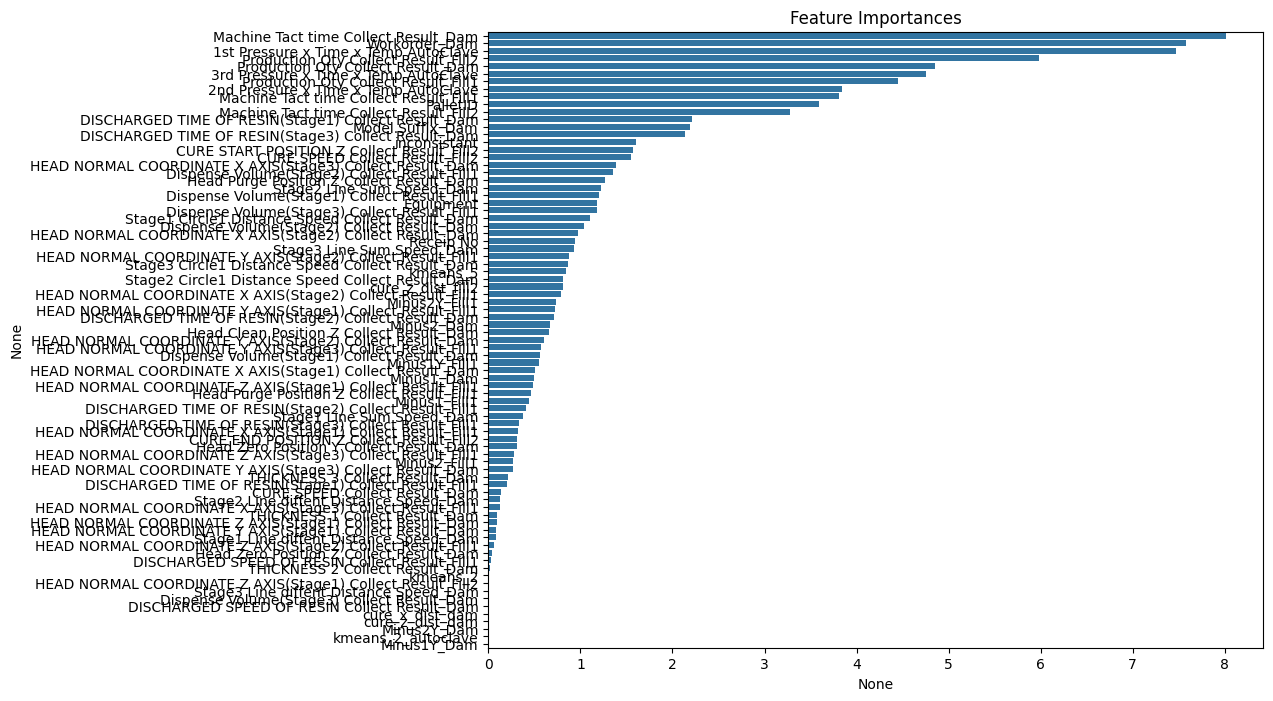

In [60]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(cat_best_model.feature_importances_, index=list(X_train_cat_last.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [61]:
# valid 확인하기
pred = cat_best_model.predict(X_valid_cat_last)
get_clf_eval(y_valid_cat_last, pred)

오차행렬:
 [[  34  424]
 [   1 7643]]

정확도: 0.9475
정밀도: 0.9714
재현율: 0.0742
F1: 0.1379


In [62]:
pred_cat_valid = cat_best_model.predict_proba(X_valid_cat_last)[:, 1]
pred_cat_valid

array([0.05438018, 0.03663388, 0.00718793, ..., 0.15495159, 0.15133198,
       0.03104581])

In [63]:
a = pd.DataFrame({'index': X_valid_cat_last.index, 'pred': pred_cat_valid})
a.to_csv('./data/catboost_valid_pred.csv', index = False)

In [64]:
# 최적의 threshold와 그 때의 예측 값 가져오기
threshold_cat, y_pred_custom_threshold_cat = model_best_threshold(cat_best_model, X_valid_cat_last, y_valid_cat_last)
get_clf_eval(y_valid_cat_last, y_pred_custom_threshold_cat)

오차행렬:
 [[ 104  354]
 [ 415 7229]]

정확도: 0.9051
정밀도: 0.2004
재현율: 0.2271
F1: 0.2129


In [65]:
# tmp
proba1 = cat_best_model.predict_proba(X_valid_cat_last)[:, 1]

#### LGBM

In [66]:
lgbm_best_params["random_state"] = 42  # LightGBM에서는 random_state를 사용합니다.
lgbm_best_model = LGBMClassifier(**lgbm_best_params)
lgbm_best_model.fit(X_train_lgbm_last, y_train_lgbm_last, categorical_feature=cat_features_indices)

LGBMClassifier(colsample_bytree=0.2484675793960146,
               learning_rate=0.009588418536116118, max_depth=42,
               min_child_samples=38, min_child_weight=3.228664519418552,
               n_estimators=1142, num_leaves=64, random_state=42,
               reg_alpha=0.02344574163871334, reg_lambda=0.0011066835670797846,
               subsample=0.4047844499396721)

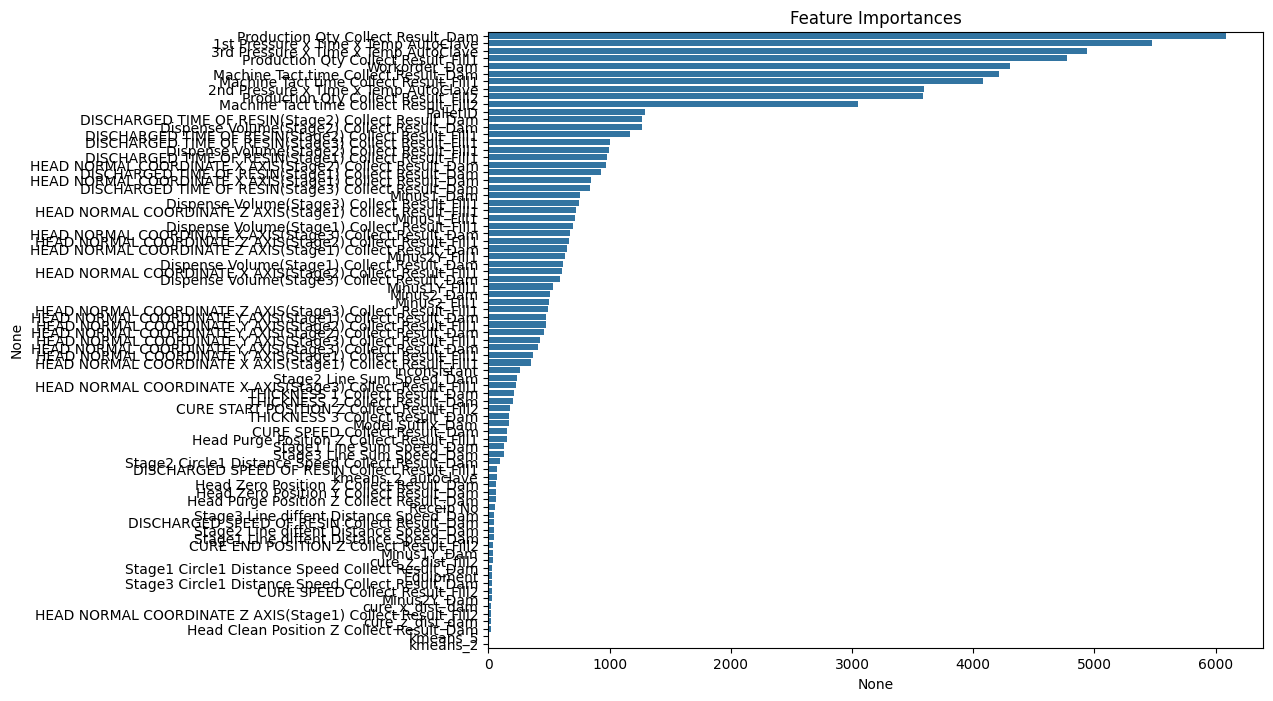

In [67]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(lgbm_best_model.feature_importances_, index=list(X_train_lgbm_last.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [68]:
pred = lgbm_best_model.predict(X_valid_lgbm_last)
get_clf_eval(y_valid_lgbm_last, pred)

오차행렬:
 [[  34  424]
 [   3 7641]]

정확도: 0.9473
정밀도: 0.9189
재현율: 0.0742
F1: 0.1374


In [69]:
# 최적의 threshold와 그 때의 예측 값 가져오기
threshold_lgbm, y_pred_custom_threshold_lgbm = model_best_threshold(lgbm_best_model, X_valid_lgbm_last, y_valid_lgbm_last)
get_clf_eval(y_valid_lgbm_last, y_pred_custom_threshold_lgbm)

오차행렬:
 [[  92  366]
 [ 258 7386]]

정확도: 0.9230
정밀도: 0.2629
재현율: 0.2009
F1: 0.2277


In [70]:
proba2 = lgbm_best_model.predict_proba(X_valid_lgbm_last)[:, 1]

#### XGB

In [71]:
# 최적의 하이퍼파라미터로 모델 재학습
xgb_best_params["random_state"] = 42
xgb_best_model = XGBClassifier(**xgb_best_params)
xgb_best_model.fit(X_train_xgb_last, y_train_xgb_last)

XGBClassifier(alpha=0.0011969062590495645, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6003955000189914, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=2.064226397646502,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=8.840212824738314,
              learning_rate=0.9923551132010517, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=819, n_jobs=None, ...)

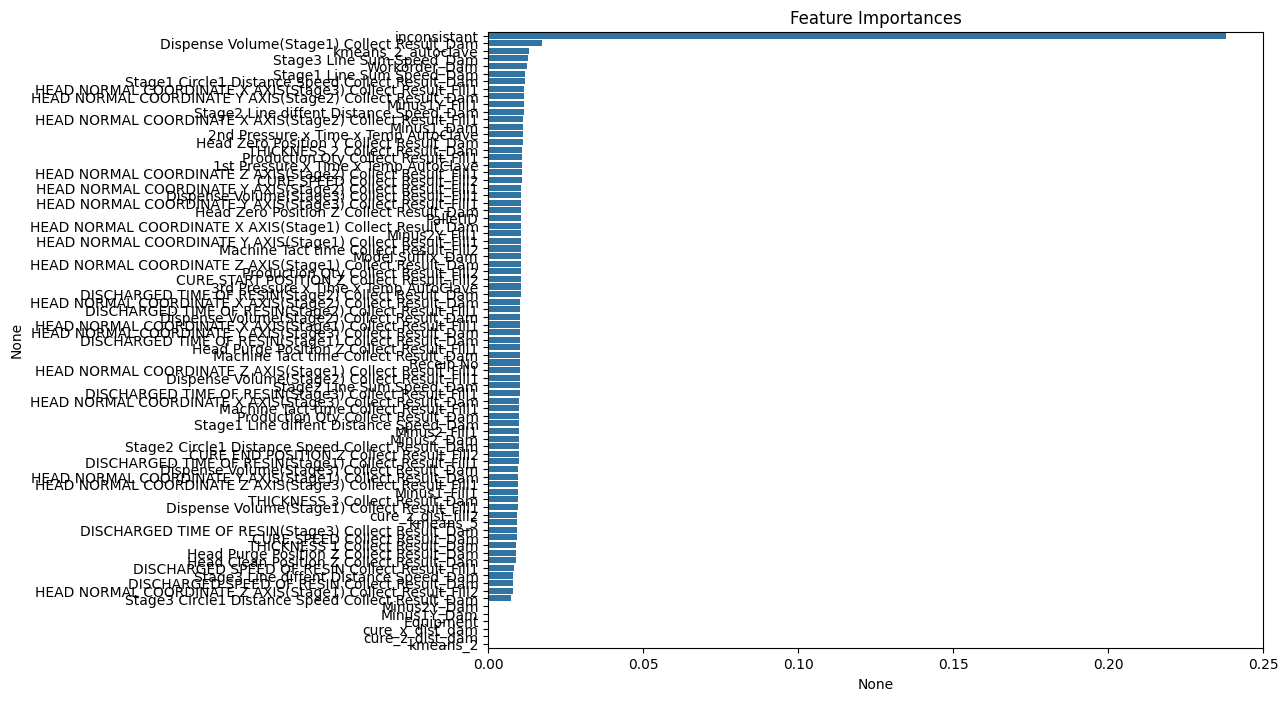

In [72]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(xgb_best_model.feature_importances_, index=list(X_train_xgb_last.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [73]:
pred = xgb_best_model.predict(X_valid_xgb_last)
get_clf_eval(y_valid_xgb_last, pred)

오차행렬:
 [[  46  412]
 [ 118 7526]]

정확도: 0.9346
정밀도: 0.2805
재현율: 0.1004
F1: 0.1479


In [74]:
# 최적의 threshold와 그 때의 예측 값 가져오기
threshold_xgb, y_pred_custom_threshold_xgb = model_best_threshold(xgb_best_model, X_valid_xgb_last, y_valid_xgb_last)
get_clf_eval(y_valid_xgb_last, y_pred_custom_threshold_xgb)

오차행렬:
 [[ 118  340]
 [ 634 7010]]

정확도: 0.8798
정밀도: 0.1569
재현율: 0.2576
F1: 0.1950


In [75]:
proba3 = xgb_best_model.predict_proba(X_valid_xgb_last)[:, 1]

## 6. Inference

### Catboost

In [76]:
# 최적의 하이퍼파라미터로 모델 재학습
cat_best_params["random_seed"] = 42
cat_best_model = CatBoostClassifier(**cat_best_params)
cat_best_model.fit(X_cat, y_cat, cat_features=cat_features_indices)

0:	learn: 0.5248363	total: 108ms	remaining: 40.7s
1:	learn: 0.4180206	total: 165ms	remaining: 31.2s
2:	learn: 0.3500299	total: 199ms	remaining: 25s
3:	learn: 0.3064346	total: 245ms	remaining: 23.1s
4:	learn: 0.2781896	total: 260ms	remaining: 19.5s
5:	learn: 0.2588605	total: 377ms	remaining: 23.5s
6:	learn: 0.2466648	total: 443ms	remaining: 23.6s
7:	learn: 0.2372203	total: 570ms	remaining: 26.5s
8:	learn: 0.2304802	total: 701ms	remaining: 28.9s
9:	learn: 0.2242916	total: 827ms	remaining: 30.6s
10:	learn: 0.2217831	total: 850ms	remaining: 28.5s
11:	learn: 0.2184888	total: 897ms	remaining: 27.5s
12:	learn: 0.2165948	total: 1.01s	remaining: 28.6s
13:	learn: 0.2155139	total: 1.05s	remaining: 27.5s
14:	learn: 0.2137057	total: 1.17s	remaining: 28.4s
15:	learn: 0.2128380	total: 1.21s	remaining: 27.5s
16:	learn: 0.2118562	total: 1.27s	remaining: 27.1s
17:	learn: 0.2104003	total: 1.39s	remaining: 27.9s
18:	learn: 0.2091198	total: 1.51s	remaining: 28.7s
19:	learn: 0.2078801	total: 1.64s	remaining

162:	learn: 0.1914739	total: 17.1s	remaining: 22.7s
163:	learn: 0.1913997	total: 17.2s	remaining: 22.7s
164:	learn: 0.1912995	total: 17.3s	remaining: 22.6s
165:	learn: 0.1912439	total: 17.4s	remaining: 22.5s
166:	learn: 0.1912137	total: 17.6s	remaining: 22.4s
167:	learn: 0.1912134	total: 17.6s	remaining: 22.2s
168:	learn: 0.1909756	total: 17.7s	remaining: 22.1s
169:	learn: 0.1909752	total: 17.8s	remaining: 22s
170:	learn: 0.1909246	total: 17.9s	remaining: 21.9s
171:	learn: 0.1909245	total: 18s	remaining: 21.7s
172:	learn: 0.1909244	total: 18s	remaining: 21.5s
173:	learn: 0.1908015	total: 18.1s	remaining: 21.4s
174:	learn: 0.1907529	total: 18.3s	remaining: 21.4s
175:	learn: 0.1907160	total: 18.4s	remaining: 21.3s
176:	learn: 0.1907157	total: 18.4s	remaining: 21.1s
177:	learn: 0.1905506	total: 18.5s	remaining: 21s
178:	learn: 0.1903953	total: 18.7s	remaining: 21s
179:	learn: 0.1902336	total: 18.8s	remaining: 20.9s
180:	learn: 0.1902334	total: 18.8s	remaining: 20.7s
181:	learn: 0.1901485	

323:	learn: 0.1836738	total: 32s	remaining: 5.54s
324:	learn: 0.1836737	total: 32.1s	remaining: 5.42s
325:	learn: 0.1836137	total: 32.2s	remaining: 5.33s
326:	learn: 0.1836137	total: 32.2s	remaining: 5.22s
327:	learn: 0.1836136	total: 32.3s	remaining: 5.11s
328:	learn: 0.1836136	total: 32.3s	remaining: 5s
329:	learn: 0.1835722	total: 32.4s	remaining: 4.91s
330:	learn: 0.1835722	total: 32.5s	remaining: 4.8s
331:	learn: 0.1835721	total: 32.5s	remaining: 4.7s
332:	learn: 0.1835318	total: 32.6s	remaining: 4.61s
333:	learn: 0.1834423	total: 32.8s	remaining: 4.51s
334:	learn: 0.1834422	total: 32.8s	remaining: 4.41s
335:	learn: 0.1834196	total: 32.9s	remaining: 4.31s
336:	learn: 0.1833522	total: 33s	remaining: 4.22s
337:	learn: 0.1832796	total: 33.2s	remaining: 4.12s
338:	learn: 0.1832795	total: 33.2s	remaining: 4.02s
339:	learn: 0.1832631	total: 33.4s	remaining: 3.92s
340:	learn: 0.1832357	total: 33.5s	remaining: 3.83s
341:	learn: 0.1832356	total: 33.5s	remaining: 3.73s
342:	learn: 0.1832355

In [77]:
# pred
cat_pred = cat_best_model.predict(X_test_cat)

In [78]:
np.unique(cat_pred, return_counts = True)

(array([0, 1]), array([17282,    79]))

### LGBM

In [79]:
# 최적의 하이퍼파라미터로 모델 재학습
lgbm_best_params["random_seed"] = 42
lgbm_best_model = LGBMClassifier(**lgbm_best_params)
lgbm_best_model.fit(X_lgbm, y_lgbm, categorical_feature=cat_features_indices)

LGBMClassifier(colsample_bytree=0.2484675793960146,
               learning_rate=0.009588418536116118, max_depth=42,
               min_child_samples=38, min_child_weight=3.228664519418552,
               n_estimators=1142, num_leaves=64, random_seed=42,
               random_state=42, reg_alpha=0.02344574163871334,
               reg_lambda=0.0011066835670797846, subsample=0.4047844499396721)

In [80]:
# pred
lgbm_pred = lgbm_best_model.predict(X_test_lgbm)

In [81]:
np.unique(lgbm_pred, return_counts = True)

(array([0, 1]), array([17280,    81]))

### XGB

In [82]:
# 최적의 하이퍼파라미터로 모델 재학습
xgb_best_params["random_seed"] = 42
xgb_best_model = XGBClassifier(**xgb_best_params)
xgb_best_model.fit(X_xgb, y_xgb)

/home/elicer/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:47:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "random_seed" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=0.0011969062590495645, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6003955000189914, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=2.064226397646502,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=8.840212824738314,
              learning_rate=0.9923551132010517, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=819, n_jobs=None, ...)

In [83]:
# pred
xgb_pred = xgb_best_model.predict(X_test_xgb)

In [84]:
np.unique(xgb_pred, return_counts = True)

(array([0, 1]), array([17006,   355]))

In [85]:
len(proba1)

8102

In [86]:
# best ensemble
best_f1 = 0
best_f1_t = 0
best_weights = None
best_weights_t = None

# 가중치 조합 테스트
for w1 in range(1, 10):
    for w2 in range(0, 10):
        for w3 in range(0, 10):
                # 가중 평균 계산
                final_proba = (w1 * proba1 + w2 * proba2 + w3 * proba3) / (w1 + w2 + w3)
                y_pred = (final_proba > 0.5).astype(int)
            
                # F1 스코어 계산
                f1 = f1_score(y_valid_xgb_last, y_pred)
                print(f1)
                
                # Threshold 스코어 계산
                precision, recall, thresholds = precision_recall_curve(y_valid_xgb_last, final_proba)
                f1_scores = 2*recall*precision / (recall + precision)
                best_threshold = thresholds[np.argmax(f1_scores)]
                y_pred_custom_threshold = (final_proba >= best_threshold).astype(int)
                f1_t = f1_score(y_valid_xgb_last, y_pred_custom_threshold)

                # 최고 성능 저장
                if f1 > best_f1:
                    best_f1 = f1
                    best_weights = (w1, w2, w3)
                
                if f1_t > best_f1_t:
                    best_f1_t = f1_t
                    best_weights_t = (w1, w2, w3)

print("Best F1 Score: ", best_f1)
print("Best Weights: ", best_weights)

0.13793103448275865
0.14728682170542637
0.14909090909090908
0.15140845070422534
0.14827586206896554
0.15042735042735042
0.14890016920473775
0.1476510067114094
0.14617940199335547
0.14925373134328357
0.13821138211382114
0.13333333333333336
0.1436893203883495
0.15157116451016636
0.1518987341772152
0.15602836879432624
0.15384615384615383
0.14930555555555555
0.14457831325301204
0.15017064846416384
0.13793103448275865
0.13360323886639677
0.13627254509018039
0.14671814671814673
0.15671641791044777
0.15356489945155394
0.1518987341772152
0.1530249110320285
0.15492957746478872
0.15384615384615383
0.1338742393509128
0.13414634146341464
0.13279678068410464
0.13861386138613863
0.14671814671814673
0.1509433962264151
0.15441176470588236
0.1527272727272727
0.1516245487364621
0.15000000000000002
0.1338742393509128
0.13793103448275865
0.13306451612903225
0.13627254509018039
0.14509803921568626
0.15
0.1509433962264151
0.15526802218114605
0.15384615384615385
0.15245009074410162
0.1338742393509128
0.13793

0.13654618473895586
0.136
0.137524557956778
0.14341085271317827
0.13821138211382114
0.13821138211382114
0.13793103448275865
0.13414634146341464
0.13360323886639677
0.13333333333333336
0.13709677419354843
0.1368209255533199
0.13833992094861658
0.1372549019607843
0.13821138211382114
0.13821138211382114
0.13821138211382114
0.13414634146341464
0.1338742393509128
0.13333333333333336
0.13333333333333336
0.1368209255533199
0.13627254509018039
0.13806706114398423
0.14198782961460446
0.13821138211382114
0.13441955193482688
0.13414634146341464
0.13414634146341464
0.13333333333333336
0.13333333333333336
0.1368209255533199
0.1368209255533199
0.1357285429141717
0.14198782961460446
0.13441955193482688
0.13441955193482688
0.13441955193482688
0.13414634146341464
0.13333333333333336
0.13333333333333336
0.13333333333333336
0.1368209255533199
0.13627254509018039
0.14198782961460446
0.13821138211382114
0.13441955193482688
0.13441955193482688
0.13414634146341464
0.13333333333333336
0.13333333333333336
0.13

0.1338742393509128
0.13333333333333336
0.13333333333333336
Best F1 Score:  0.15671641791044777
Best Weights:  (1, 2, 4)


In [87]:
best_f1_t

0.23668639053254437

In [88]:
best_weights_t

(5, 6, 0)

In [100]:
# best ensemble 적용
cat = proba1 * 5
lgbm = proba2 * 6
xgb = proba3 * 0
y_best = (cat + lgbm + xgb)/(5 + 6 + 0)

In [101]:
precision, recall, thresholds = precision_recall_curve(y_valid_xgb_last, y_best)
f1_scores = 2*recall*precision / (recall + precision)
weights_best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_best >= weights_best_threshold).astype(int)
get_clf_eval(y_valid_xgb_last, y_pred_custom_threshold)

오차행렬:
 [[ 100  358]
 [ 287 7357]]

정확도: 0.9204
정밀도: 0.2584
재현율: 0.2183
F1: 0.2367


In [102]:
# proba
xgb_proba = xgb_best_model.predict_proba(X_test_xgb)[:, 1]
cat_proba = cat_best_model.predict_proba(X_test_cat)[:, 1]
lgbm_proba = lgbm_best_model.predict_proba(X_test_lgbm)[:, 1]

In [103]:
# 추론
cat = cat_proba * 5
lgbm = lgbm_proba * 6
xgb = xgb_proba * 0
p = (cat + lgbm + xgb)/(5 + 6 + 0)

In [104]:
p2 = np.where(p >= weights_best_threshold, 'AbNormal', 'Normal')

In [105]:
np.unique(p2, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([  703, 16658]))

In [106]:
p3 = np.where(cat_proba >= 0.5, 'AbNormal', 'Normal')

In [107]:
np.unique(p3, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([   79, 17282]))

In [108]:
pd.crosstab(p2, df_test['inconsistant'])

inconsistant,0,1
row_0,,
AbNormal,675,28
Normal,16658,0


## 7. Submission

In [109]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = p2

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [110]:
df_sub['target']

0        Normal
1        Normal
2        Normal
3        Normal
4        Normal
          ...  
17356    Normal
17357    Normal
17358    Normal
17359    Normal
17360    Normal
Name: target, Length: 17361, dtype: object

# 꼭 df_sub['target'] 확인하고 제출하시오